<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Prediction_of_Dry_Ice_Sublimation_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [2]:
# @title 1) Setup for the dry ice prediction
# One chart per figure; matplotlib only; no explicit colors.

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250

In [3]:
# @title 2) Clausius–Clapeyron model (dataclass, T-independent ΔH_sub)
@dataclass(frozen=True)
class CO2SublimationModel:
    """Clausius–Clapeyron model for CO₂ sublimation pressure.

    Uses ln P(T) = -ΔH_sub/(R T) + C with C fixed by the triple point (T_t, P_t).
    Assumes ΔH_sub is weakly T-dependent over the plotted range and treats it
    as constant for this demonstration.

    Attributes:
        delta_h_sub_j_per_mol: Enthalpy of sublimation [J/mol].
        triple_t_k: Triple-point temperature [K].
        triple_p_pa: Triple-point pressure [Pa].
    """

    delta_h_sub_j_per_mol: float = 25.23e3  # ~25–26 kJ/mol near ~195 K
    triple_t_k: float = 216.58              # CO₂ triple point [K]
    triple_p_pa: float = 5.185e5            # CO₂ triple point [Pa] (5.185 bar)

    R_J_PER_MOLK: float = 8.314462618       # universal gas constant

    @property
    def _C(self) -> float:
        """Integration constant C for ln P(T) = -ΔH/(R T) + C, fixed at the triple point."""
        return math.log(self.triple_p_pa) + self.delta_h_sub_j_per_mol / (
            self.R_J_PER_MOLK * self.triple_t_k
        )

    def pressure_pa(self, T_K: np.ndarray | float) -> np.ndarray | float:
        """Return sublimation pressure P(T) in pascals."""
        T_arr = np.asarray(T_K, dtype=float)
        expo = -self.delta_h_sub_j_per_mol / (self.R_J_PER_MOLK * T_arr) + self._C
        return np.exp(expo)

    def predict_temperature_K(self, p_target_pa: float) -> float:
        """Return T [K] such that P_sub(T) = p_target_pa."""
        denom = self._C - math.log(p_target_pa)
        return self.delta_h_sub_j_per_mol / (self.R_J_PER_MOLK * denom)

=== Numerical Result ===
Predicted sublimation temperature @ 1 atm: 193.977 K  (-79.173 °C)
Reference value (not used in fit):         -78.500 °C
Absolute error:                             0.673 °C
Figure saved to: /content/co2_sublimation_ambient_prediction.png


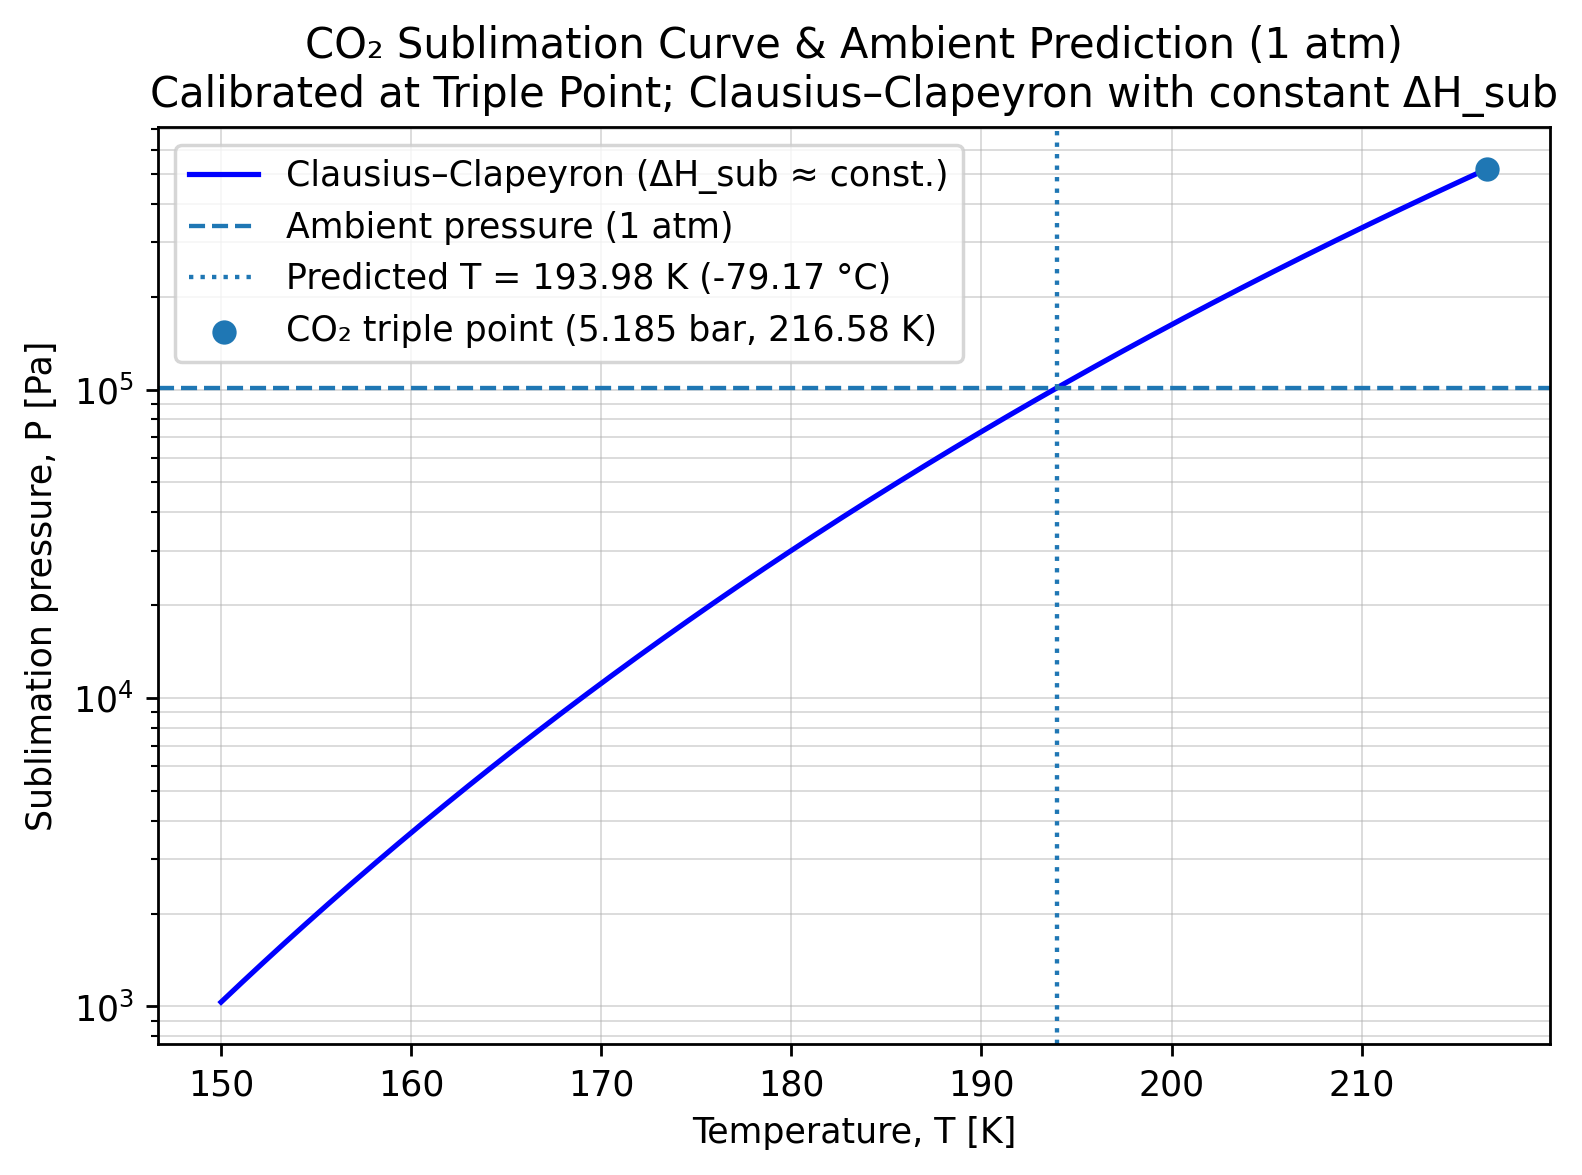

In [4]:
# @title 3) Control knobs → prediction → single-figure plot & save
# ---- Control knobs ----
AMBIENT_PRESSURE_PA = 101_325.0         # 1 atm
DELTA_H_SUB_J_PER_MOL = 25.23e3         # try 25.9e3–26.0e3 to tighten match
T_MIN_K, T_MAX_K = 150.0, 216.58        # up to triple point
N_POINTS = 600
SAVE_PATH = "/content/co2_sublimation_ambient_prediction.png"

# ---- Build model & predict T at 1 atm ----
model = CO2SublimationModel(delta_h_sub_j_per_mol=DELTA_H_SUB_J_PER_MOL)
T_pred_K = model.predict_temperature_K(AMBIENT_PRESSURE_PA)
T_pred_C = T_pred_K - 273.15

# Reference for comparison (not used in the fit)
T_ref_C = -78.5
abs_err_C = abs(T_pred_C - T_ref_C)

# ---- Generate curve ----
T_grid_K = np.linspace(T_MIN_K, T_MAX_K, N_POINTS)
P_grid_Pa = model.pressure_pa(T_grid_K)

# ---- Plot: one chart, no explicit colors ----
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.plot(T_grid_K, P_grid_Pa, label="Clausius–Clapeyron (ΔH_sub ≈ const.)", color='blue')
ax.axhline(AMBIENT_PRESSURE_PA, linestyle="--", linewidth=1.25, label="Ambient pressure (1 atm)")
ax.axvline(T_pred_K, linestyle=":", linewidth=1.25,
           label=f"Predicted T = {T_pred_K:.2f} K ({T_pred_C:.2f} °C)")
ax.scatter([model.triple_t_k], [model.triple_p_pa], marker="o", zorder=3,
           label="CO₂ triple point (5.185 bar, 216.58 K)")

ax.set_yscale("log")
ax.set_xlabel("Temperature, T [K]")
ax.set_ylabel("Sublimation pressure, P [Pa]")
ax.set_title("CO₂ Sublimation Curve & Ambient Prediction (1 atm)\n"
             "Calibrated at Triple Point; Clausius–Clapeyron with constant ΔH_sub")
ax.grid(True, which="both", linewidth=0.5, alpha=0.5)
ax.legend()
fig.tight_layout()
#fig.savefig(SAVE_PATH, dpi=250)

print("=== Numerical Result ===")
print(f"Predicted sublimation temperature @ 1 atm: {T_pred_K:.3f} K  ({T_pred_C:.3f} °C)")
print(f"Reference value (not used in fit):         {T_ref_C:.3f} °C")
print(f"Absolute error:                             {abs_err_C:.3f} °C")
print(f"Figure saved to: {SAVE_PATH}")

plt.show()

In [5]:
# @title 4) Calibrate ΔH_sub to hit a target temperature exactly (bisection)
# This demonstrates the mild sensitivity of the prediction to ΔH_sub.
TARGET_T_C = -78.5
TARGET_T_K = TARGET_T_C + 273.15

def predict_T_for(delta_h_sub_j_per_mol: float) -> float:
    """Helper: temperature [K] at 1 atm for a given ΔH_sub."""
    m = CO2SublimationModel(delta_h_sub_j_per_mol=delta_h_sub_j_per_mol)
    return m.predict_temperature_K(101_325.0)

# Simple bisection on ΔH_sub in a plausible bracket
lo, hi = 24.0e3, 27.0e3
for _ in range(40):
    mid = 0.5 * (lo + hi)
    T_mid = predict_T_for(mid)
    if (T_mid - TARGET_T_K) > 0.0:
        # If predicted T is too high, increase denominator → increase ΔH_sub
        hi = mid
    else:
        lo = mid

calibrated_dH = 0.5 * (lo + hi)
T_cal_K = predict_T_for(calibrated_dH)
T_cal_C = T_cal_K - 273.15

print("=== ΔH_sub calibration via bisection ===")
print(f"Calibrated ΔH_sub: {calibrated_dH/1e3:.3f} kJ/mol")
print(f"T(1 atm) with calibrated ΔH_sub: {T_cal_K:.3f} K  ({T_cal_C:.3f} °C)")

=== ΔH_sub calibration via bisection ===
Calibrated ΔH_sub: 26.095 kJ/mol
T(1 atm) with calibrated ΔH_sub: 194.650 K  (-78.500 °C)


The next section is about how dry ice sublimates over time based on known volumes (sizes) of dry ice blocks that can be purchased from a convenience store.

In [6]:
# @title 1) Imports, constants, and references (250 dpi)
# Self-contained; uses only NumPy, Pandas, Matplotlib (all preinstalled on Colab).

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250

SIGMA = 5.670374419e-8  # Stefan–Boltzmann constant [W/m²·K⁴]

# --- Material properties for solid CO2 ("dry ice") ---
# Density ~1.56 g/cm³ near the sublimation temperature (−79 °C),
# and latent heat of sublimation ΔH_sub ≈ 571 kJ/kg (≈25.2–26.1 kJ/mol across 167–207 K).
RHO_CO2_KG_M3 = 1560.0       # [kg/m³]
L_SUB_J_KG    = 571_000.0    # [J/kg]

# --- Geometry helpers: block sizes used below ---
IN_TO_M = 0.0254
CM_TO_M = 0.01

# 10 lb block (common retail cut ~10×10×2 in)
TEN_LB_BLOCK = (10*IN_TO_M, 10*IN_TO_M, 2*IN_TO_M)

# 5 lb block (common retail cut ~10×5×2 in)
FIVE_LB_BLOCK = (10*IN_TO_M, 5*IN_TO_M, 2*IN_TO_M)

# 3×3×2 cm explicit sample
SMALL_BLOCK_CM = (3*CM_TO_M, 3*CM_TO_M, 2*CM_TO_M)

In [7]:
# @title 2) Model: convection + radiation into a shrinking shape (A ∝ m^{2/3})

@dataclass(frozen=True)
class Env:
    """Room/environment settings for sublimation-time prediction."""
    T_amb_C: float = 21.0       # Ambient temperature [°C]
    T_surf_C: float = -78.5     # Dry ice surface ~ equilibrium sublimation temperature @ 1 atm [°C]
    h_W_m2K: float = 10.0       # Natural-convection coefficient (still air) [W/m²·K]
    emissivity: float = 0.85    # Hemispherical emissivity of CO2 ice (thermal IR) [–]
    f_exposed: float = 1.0      # Fraction of faces effectively exchanging heat (1.0=rack; ~5/6=countertop)

    @property
    def T_amb_K(self) -> float:
        return self.T_amb_C + 273.15

    @property
    def T_surf_K(self) -> float:
        return self.T_surf_C + 273.15

    @property
    def dT(self) -> float:
        return self.T_amb_K - self.T_surf_K

    @property
    def q_per_area_W_m2(self) -> float:
        """Total heat flux [W/m²] = convection + radiation."""
        q_conv = self.h_W_m2K * (self.T_amb_K - self.T_surf_K)
        q_rad = self.emissivity * SIGMA * (self.T_amb_K**4 - self.T_surf_K**4)
        return q_conv + q_rad


@dataclass(frozen=True)
class MaterialCO2:
    rho_kg_m3: float = RHO_CO2_KG_M3
    L_sub_J_kg: float = L_SUB_J_KG


def shape_kappa_rect_prism(a: float, b: float, c: float) -> float:
    """Return κ such that A = κ * V^{2/3} for a rectangular prism with sides a,b,c (any consistent units)."""
    V = a*b*c
    A = 2.0*(a*b + b*c + a*c)
    return A / (V**(2.0/3.0))


def time_to_sublimate_hours(m0_kg: float, kappa: float, env: Env, mat: MaterialCO2) -> float:
    r"""Shrinking-shape, energy-limited sublimation time (hours).

    Assumptions:
      • Surface stays near the CO₂ sublimation equilibrium temperature at 1 atm (≈ −78.5 °C).
      • Heat flux into the surface is energy-limiting (all arriving heat pays ΔH_sub to sublimate).
      • Shape remains similar while shrinking ⇒ surface area A ∝ m^{2/3} (κ carries the aspect ratio).

    Derivation (sketch):
      dm/dt = − (q'' * A) / L_sub, with A = κ * (m/ρ)^{2/3}.
      ⇒ dm/dt = − C * m^{2/3}, C = q'' * κ / (L_sub * ρ^{2/3}) .
      Integrate from m0 to 0:  t* = 3 * L_sub * ρ^{2/3} * m0^{1/3} / (κ * q'').
      If only a fraction f_exposed of faces exchange heat, scale q'' → f_exposed * q''.

    Returns:
      Time to vanish [hours].
    """
    qpp = env.f_exposed * env.q_per_area_W_m2
    t_seconds = 3.0 * mat.L_sub_J_kg * (mat.rho_kg_m3**(2.0/3.0)) * (m0_kg**(1.0/3.0)) / (kappa * qpp)
    return t_seconds / 3600.0

Dry ice sublimation time predictions (hours)

Scenario             CENTRAL (typical still air)  CENTRAL + countertop (5/6 faces)  HIGH heat (small breeze, high ε)  LOW heat (still air, low ε)
Item                                                                                                                                             
10 lb (≈10×10×2 in)                        10.06                             12.07                              6.95                        16.76
3×3×2 cm block                              2.47                              2.97                              1.71                         4.12
5 lb  (≈10×5×2 in)                          8.80                             10.56                              6.08                        14.67

Saved: /content/dry_ice_time_predictions_hours.csv
Saved figure: /content/dry_ice_time_scaling.png


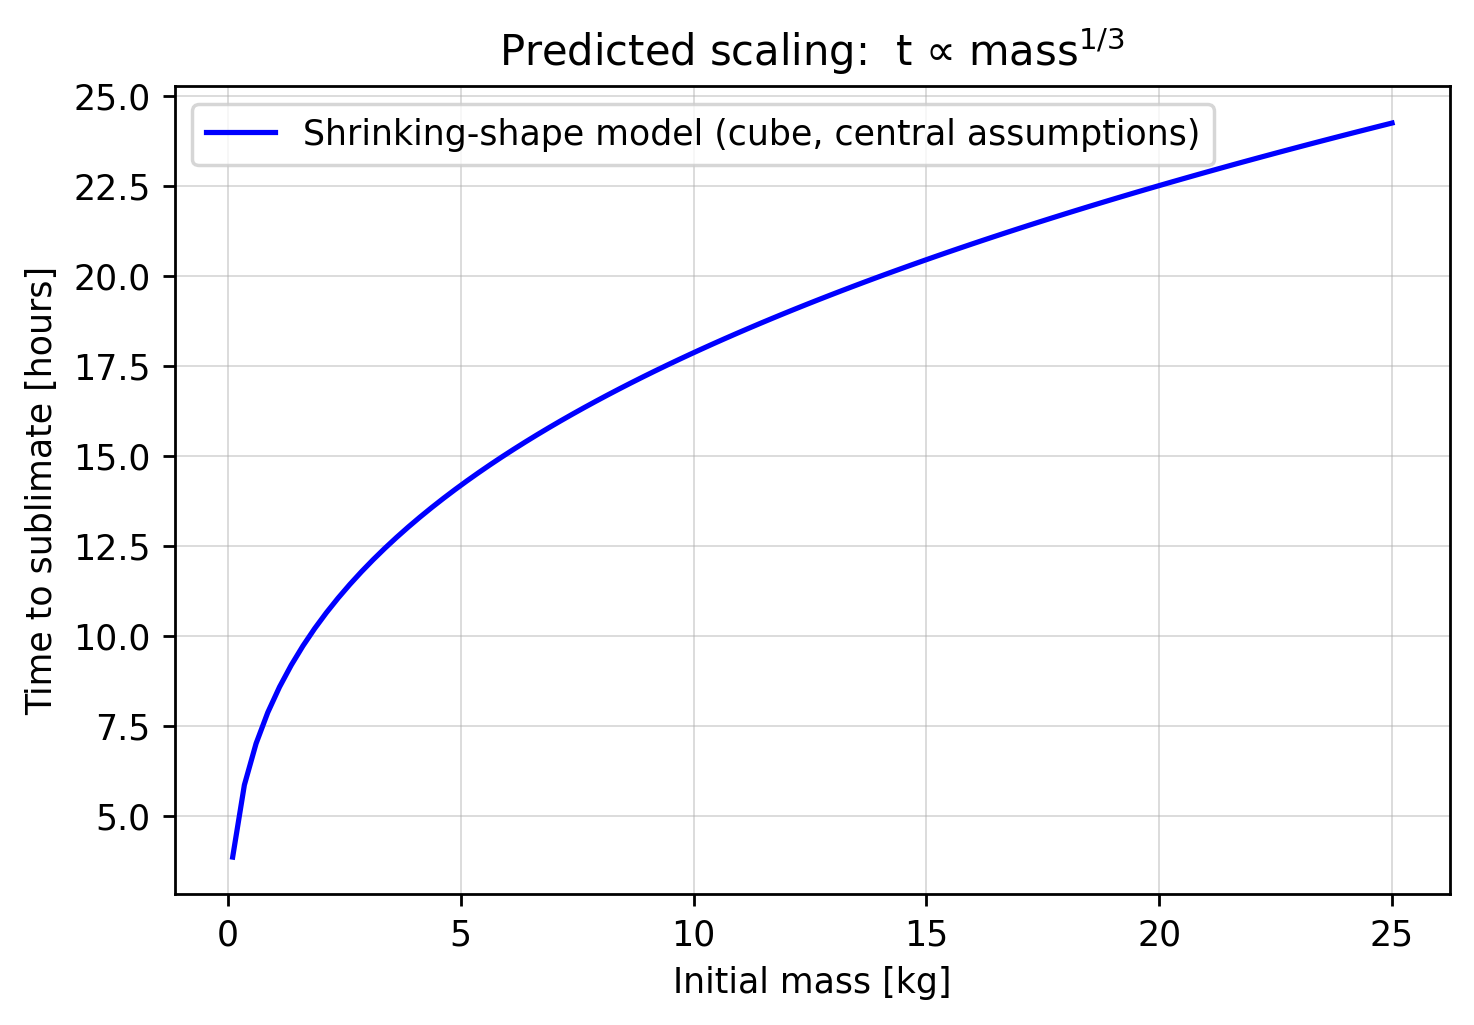

In [8]:
# @title 3) Evaluate: 10 lb, 5 lb, and 3×3×2 cm blocks; print table; plot scaling
mat = MaterialCO2()

# Masses from weight or density
m10_lb = 10.0 * 0.45359237  # kg
m5_lb  = 5.0  * 0.45359237  # kg
V_small = np.prod(SMALL_BLOCK_CM)           # m³
m_small = mat.rho_kg_m3 * V_small          # kg

# Shape factors κ
kappa_10 = shape_kappa_rect_prism(*TEN_LB_BLOCK)
kappa_5  = shape_kappa_rect_prism(*FIVE_LB_BLOCK)
kappa_sm = shape_kappa_rect_prism(*SMALL_BLOCK_CM)

# Scenarios (tweak freely)
scenarios = [
    ("LOW heat (still air, low ε)",       Env(T_amb_C=21.0, h_W_m2K=5.0,  emissivity=0.80, f_exposed=1.0)),
    ("CENTRAL (typical still air)",       Env(T_amb_C=21.0, h_W_m2K=10.0, emissivity=0.85, f_exposed=1.0)),
    ("HIGH heat (small breeze, high ε)",  Env(T_amb_C=24.0, h_W_m2K=15.0, emissivity=0.90, f_exposed=1.0)),
    ("CENTRAL + countertop (5/6 faces)",  Env(T_amb_C=21.0, h_W_m2K=10.0, emissivity=0.85, f_exposed=5.0/6.0)),
]

# Compute table
rows: List[Dict[str, float | str]] = []
for label, env in scenarios:
    for name, m0, kappa in [
        ("10 lb (≈10×10×2 in)", m10_lb, kappa_10),
        ("5 lb  (≈10×5×2 in)",  m5_lb,  kappa_5),
        ("3×3×2 cm block",      m_small, kappa_sm),
    ]:
        t_hr = time_to_sublimate_hours(m0, kappa, env, mat)
        rows.append({
            "Scenario": label,
            "Item": name,
            "Time_to_sublimate_hours": t_hr,
            "Heat_flux_W_per_m2": env.q_per_area_W_m2,
        })

df = pd.DataFrame(rows)
df["Time_to_sublimate_hours"] = df["Time_to_sublimate_hours"].round(2)
df["Heat_flux_W_per_m2"] = df["Heat_flux_W_per_m2"].round(1)

# Pivot for readability and show
table = df.pivot_table(index="Item", columns="Scenario", values="Time_to_sublimate_hours")
print("Dry ice sublimation time predictions (hours)\n")
print(table.to_string())

# Save CSV
table.to_csv("/content/dry_ice_time_predictions_hours.csv")
print("\nSaved: /content/dry_ice_time_predictions_hours.csv")

# Optional: show scaling with mass^(1/3) for a reference 'cube' shape
masses = np.linspace(0.1, 25.0, 100)  # kg
env_central = Env()
kappa_cube   = shape_kappa_rect_prism(1.0, 1.0, 1.0)  # κ=6 for a cube
times = [time_to_sublimate_hours(m, kappa_cube, env_central, mat) for m in masses]

fig, ax = plt.subplots(figsize=(6.0, 4.2))
ax.plot(masses, times, label="Shrinking-shape model (cube, central assumptions)", color='blue')
ax.set_xlabel("Initial mass [kg]")
ax.set_ylabel("Time to sublimate [hours]")
ax.set_title("Predicted scaling:  t ∝ mass$^{1/3}$")
ax.grid(True, which="both", linewidth=0.5, alpha=0.5)
ax.legend()
fig.tight_layout()
# fig.savefig("/content/dry_ice_time_scaling.png", dpi=250)
print("Saved figure: /content/dry_ice_time_scaling.png")

Saved: /content/dry_ice_time_scaling_with_stars.png


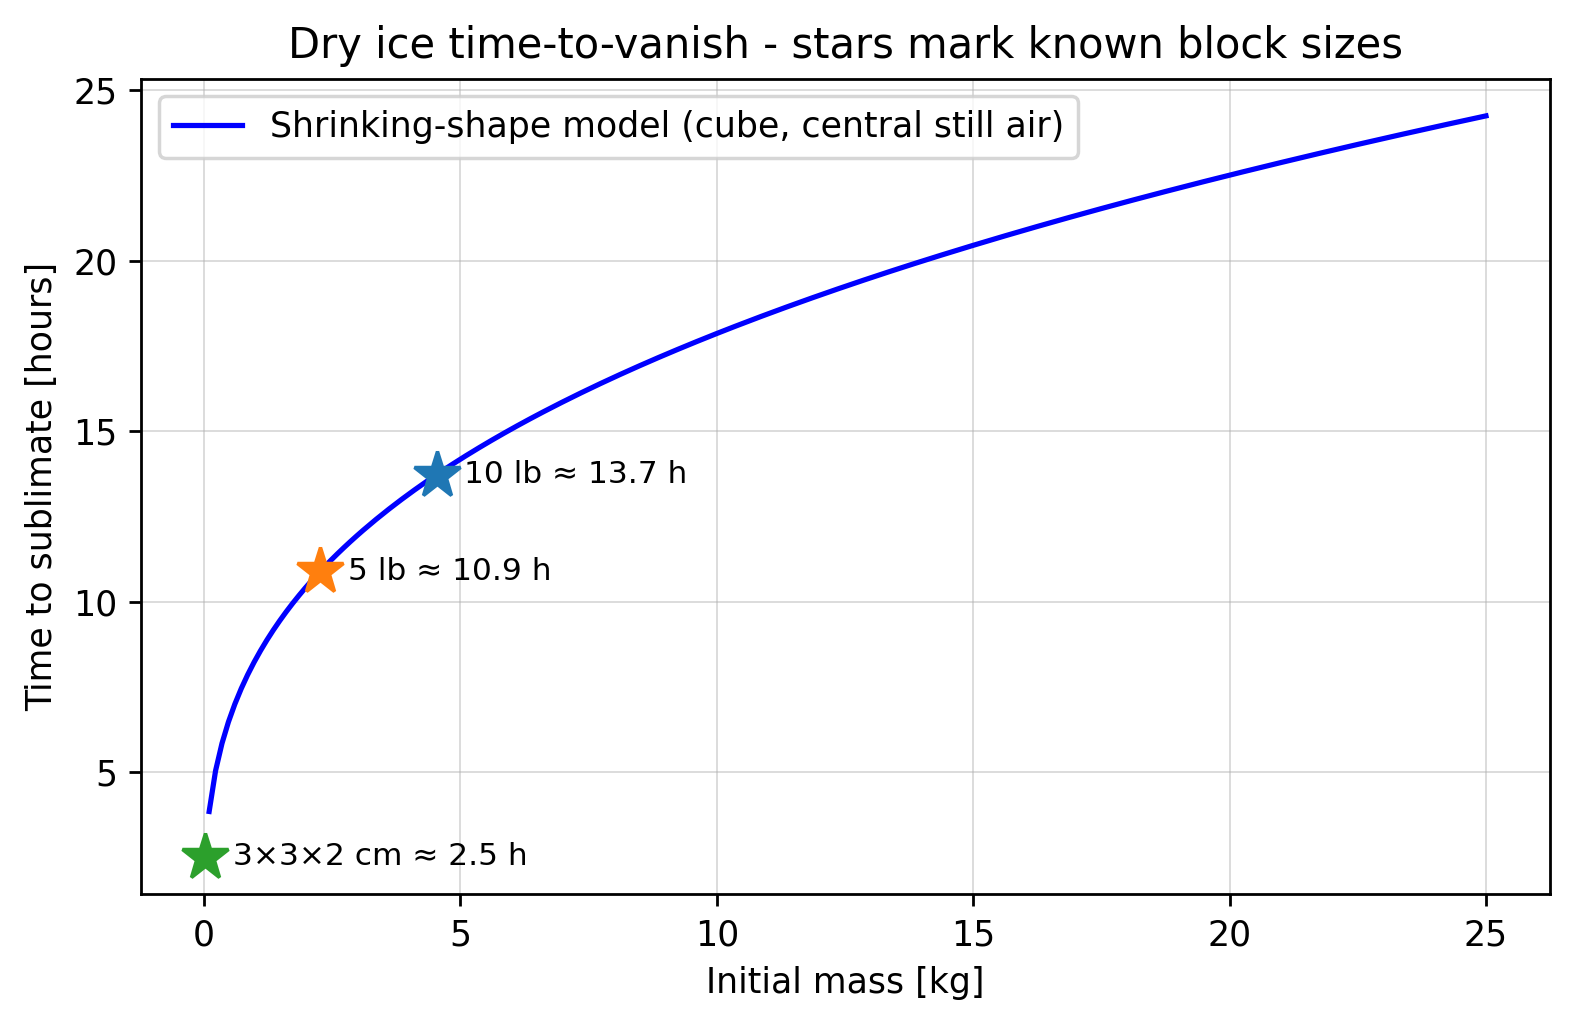

In [11]:
# Colab cell — Scaling figure with stars at requested block sizes (right-side labels)

from __future__ import annotations

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dataclasses import dataclass

mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250

SIGMA = 5.670374419e-8
RHO_CO2_KG_M3 = 1560.0
L_SUB_J_KG    = 571_000.0

@dataclass(frozen=True)
class Env:
    T_amb_C: float = 21.0
    T_surf_C: float = -78.5
    h_W_m2K: float = 10.0
    emissivity: float = 0.85
    f_exposed: float = 1.0
    @property
    def T_amb_K(self) -> float: return self.T_amb_C + 273.15
    @property
    def T_surf_K(self) -> float: return self.T_surf_C + 273.15
    @property
    def q_per_area_W_m2(self) -> float:
        q_conv = self.h_W_m2K * (self.T_amb_K - self.T_surf_K)
        q_rad  = self.emissivity * SIGMA * (self.T_amb_K**4 - self.T_surf_K**4)
        return self.f_exposed * (q_conv + q_rad)

def shape_kappa_rect_prism(a: float, b: float, c: float) -> float:
    V = a*b*c
    A = 2.0*(a*b + b*c + a*c)
    return A / (V**(2.0/3.0))

def time_to_sublimate_hours(m0_kg: float, kappa: float, env: Env) -> float:
    qpp = env.q_per_area_W_m2
    t_seconds = 3.0 * L_SUB_J_KG * (RHO_CO2_KG_M3**(2.0/3.0)) * (m0_kg**(1.0/3.0)) / (kappa*qpp)
    return t_seconds / 3600.0

# ----- Build the scaling line (cube κ) -----
env = Env()
kappa_cube = shape_kappa_rect_prism(1.0, 1.0, 1.0)  # κ = 6
masses = np.linspace(0.1, 25.0, 200)  # kg
times  = [time_to_sublimate_hours(m, kappa_cube, env) for m in masses]

# ----- Requested blocks (masses) -----
CM_TO_M = 0.01
m10_lb = 10.0 * 0.45359237
m5_lb  = 5.0  * 0.45359237
m_small = RHO_CO2_KG_M3 * (3*CM_TO_M)*(3*CM_TO_M)*(2*CM_TO_M)

# Place stars ON the line (use same κ as the line)
t10 = time_to_sublimate_hours(m10_lb, kappa_cube, env)
t5  = time_to_sublimate_hours(m5_lb,  kappa_cube, env)
ts  = time_to_sublimate_hours(m_small, kappa_cube, env)

fig, ax = plt.subplots(figsize=(6.4, 4.2))
ax.plot(masses, times, label="Shrinking-shape model (cube, central still air)", color='blue')

# Star markers (no legend labels; we annotate instead)
ax.plot([m10_lb], [t10], marker="*", markersize=14, linestyle="None")
ax.plot([m5_lb],  [t5],  marker="*", markersize=14, linestyle="None")
ax.plot([m_small],[ts],  marker="*", markersize=14, linestyle="None")

# --- Right-side labels (8 pt to the right, vertically centered) ---
RIGHT_OFFSET_PT = (8, 0)
ANNOT_KW = dict(textcoords="offset points", ha="left", va="center", fontsize=9)

ax.annotate(f"10 lb ≈ {t10:.1f} h",   xy=(m10_lb, t10), xytext=RIGHT_OFFSET_PT, **ANNOT_KW)
ax.annotate(f"5 lb ≈ {t5:.1f} h",     xy=(m5_lb,  t5),  xytext=RIGHT_OFFSET_PT, **ANNOT_KW)
ax.annotate(f"3×3×2 cm ≈ {ts:.1f} h", xy=(m_small, ts), xytext=RIGHT_OFFSET_PT, **ANNOT_KW)

ax.set_xlabel("Initial mass [kg]")
ax.set_ylabel("Time to sublimate [hours]")
ax.set_title("Dry ice time-to-vanish - stars mark known block sizes")
ax.grid(True, which="both", linewidth=0.5, alpha=0.5)
ax.legend()
fig.tight_layout()
# fig.savefig("/content/dry_ice_time_scaling_with_stars.png", dpi=250)
print("Saved: /content/dry_ice_time_scaling_with_stars.png")
plt.show()